In [1]:
from datasets import load_dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")

c:\feindrial\py_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = dataset["train"].to_pandas()
validation = dataset["validation"].to_pandas()
test = dataset["test"].to_pandas()

In [2]:
import numpy as np
import pandas as pd
import re
import spacy
import contractions
from tokenizers import decoders, models, normalizers, pre_tokenizers, processors, trainers, Tokenizer, Encoding
import tensorflow as tf
from keras.utils import pad_sequences
from keras.layers import Input, LSTM, Attention, Embedding, Dense, Concatenate, Attention, TimeDistributed
from keras.models import Model
from keras.callbacks import EarlyStopping

DATA ANALYSIS

In [4]:
train['article'].str.count('"').describe()

count    287113.000000
mean          5.805617
std          12.046182
min           0.000000
25%           0.000000
50%           0.000000
75%           6.000000
max         370.000000
Name: article, dtype: float64

In [5]:
train['article'].str.count("'").describe()

count    287113.000000
mean         17.223414
std          15.722018
min           0.000000
25%           6.000000
50%          13.000000
75%          24.000000
max         196.000000
Name: article, dtype: float64

In [6]:
train['article'].str.count("\(").describe()

count    287113.000000
mean          1.715265
std           3.242093
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         358.000000
Name: article, dtype: float64

In [7]:
print("random 10k sample number count:", len(re.findall(r'\d', train.sample(10000)['article'].str.cat())))
print("random 10k sample punct count:", len(re.findall(r'[^\w\s]', train.sample(10000)['article'].str.cat())))

random 10k sample number count: 343369
random 10k sample punct count: 1267246


In [12]:
def text_normalize(train: pd.DataFrame, validation: pd.DataFrame, test: pd.DataFrame):
    def alt_proc(alt_set: pd.DataFrame):
        alt_set = alt_set.drop(columns=["id"])

        for row_index in range(len(alt_set)):
            exp_article = contractions.fix(alt_set.iloc[row_index]["article"])
            exp_highlights = contractions.fix(alt_set.iloc[row_index]["highlights"])

            alt_set.iloc[row_index]["article"] = exp_article
            alt_set.iloc[row_index]["highlights"] = exp_highlights

        print("contractions fixed.")

        alt_set.replace(to_replace=r'\(|\)|\"|\'|\-', value='', regex=True, inplace=True)
        alt_set.replace(to_replace=r'[^\w\s]', value='', regex=True, inplace=True)
        alt_set.replace(to_replace=r'\d', value='', regex=True, inplace=True)
        alt_set.replace(to_replace=r'https?://\S+', value='', regex=True, inplace=True)

        alt_set.replace(to_replace='  ', value=' ', regex=True, inplace=True)

        print("values replaced.")

        alt_set["article"] = alt_set["article"].str.lower()
        alt_set["highlights"] = alt_set["highlights"].str.lower()

        print("characters lowered.")

        return alt_set

    return alt_proc(train), alt_proc(validation), alt_proc(test)

In [9]:
ptrain, pval, ptest = text_normalize(train, validation, test)

contractions fixed.
values replaced.
characters lowered.
contractions fixed.
values replaced.
characters lowered.
contractions fixed.
values replaced.
characters lowered.


In [13]:
ptrain.tail(10)

,article,highlights
287103,the homeowner accused of deliberately shooting...,markus kaarma fired four bullets into diren de...
287104,locals in northern new jersey believe they fil...,darsh patel was hiking with friends in the aps...
287105,a nebraska man described by one prison psychia...,prosecutors say nikko jenkins shot juan uribep...
287106,luis suarez is now the third most valuable foo...,luis suarez third in the cies football observa...
287107,russias deputy prime minister has tweeted a pi...,russias deputy prime minister dmitry rogozin u...
287108,the nineyearold daughter of a black unarmed ma...,rumain brisbon was killed after phoenix police...
287109,legalising assisted suicide is a slippery slop...,theo boer a european assisted suicide watchdog...
287110,a group calling itself the women of the percen...,ohio congressman criticised for condoning the ...
287111,most men enjoy a good pint of lager or real al...,the black country ale tairsters have been to p...
287112,a facebook page seeking to preserve the black ...,facebook page supporting tradition gains one m...


In [14]:
def train_tokenizer(train: pd.DataFrame):
    tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()

    special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
    trainer = trainers.WordPieceTrainer(vocab_size=50000, special_tokens=special_tokens)

    tokenizer.train_from_iterator(train["article"].tolist() + train["highlights"].tolist(), trainer=trainer)

    tokenizer.decoder = decoders.WordPiece(prefix="##")

    return tokenizer

In [15]:
tokenizer = train_tokenizer(ptrain)

In [30]:
longestatr = ptrain.article.map(len).max()
longestava = pval.article.map(len).max()
longestate = ptest.article.map(len).max()

longesthtr = ptrain.highlights.map(len).max()
longesthva = pval.highlights.map(len).max()
longesthte = ptest.highlights.map(len).max()

print(longestatr)
print(longestava)
print(longestate)
print("-----------")
print(longesthtr)
print(longesthva)
print(longesthte)

14953
11013
11508
-----------
7010
8201
3086


In [31]:
ptrain.article.str.len().idxmax()

151905

In [34]:
longest_enc = tokenizer.encode(ptrain["article"].iloc[151905])
msl = len(longest_enc.ids)
print(msl)

2763


SAVING TOKENIZER AND DATASET

In [15]:
tokenizer.save("./models/tokenizer/tokenizer.json")

import pickle
with open("./dataset/dttrain", "wb") as fp:
    pickle.dump(ptrain, fp)
with open("./dataset/dtval", "wb") as fp:
    pickle.dump(pval, fp)
with open("./dataset/dttest", "wb") as fp:
    pickle.dump(ptest, fp)

LOAD TOKENIZER AND DATASET

In [3]:
tokenizer = Tokenizer.from_file("./models/tokenizer/tokenizer.json")

import pickle
with open("./dataset/dttrain", "rb") as fp:  
    train = pickle.load(fp)
with open("./dataset/dtval", "rb") as fp:   
    val = pickle.load(fp)
with open("./dataset/dttest", "rb") as fp:   
    test = pickle.load(fp)

In [35]:
latent_dim = 256
embedding_dim = 256
vocab_size = tokenizer.get_vocab_size()
max_seq_len = msl + 300
batch_size = 32

In [50]:
def add_special_tokens(sequence, cls_token_id, sep_token_id):
    if sep_token_id is None:
        return np.append(cls_token_id, sequence)
    elif cls_token_id is None:
        return np.append(sequence, sep_token_id)
    else:        
        return np.append(np.append(cls_token_id, sequence), sep_token_id)

In [51]:
def shift_tokens(sequence, from_beginning, from_end):
    if from_beginning is None:
        return sequence[1:]
    elif from_end is None:        
        return sequence[:-1]
    else:
        return sequence[1:-1]

In [72]:
def create_dt(df: pd.DataFrame, tokenizer: Tokenizer):
    pad_value = tokenizer.token_to_id("[PAD]")
    cls_value = tokenizer.token_to_id("[CLS]")
    sep_value = tokenizer.token_to_id("[SEP]")

    adocs = df["article"].tolist()
    hdocs = df["highlights"].tolist()    

    for index in range(len(adocs)):
        encodingX = tokenizer.encode(adocs[index])
        encodingy = tokenizer.encode(hdocs[index])

        dt = (encodingX.ids, encodingy.ids)

        dtE = add_special_tokens(dt[0], cls_token_id=cls_value, sep_token_id=sep_value)
        dtE = pad_sequences([dtE], maxlen=max_seq_len, padding='post', value=pad_value)
        dtE = np.expand_dims(dtE, -1)
        dtE = np.squeeze(dtE, axis=0)

        dtD = shift_tokens(dt[1], from_beginning=True, from_end=None)
        dtD = add_special_tokens(dtD, cls_token_id=cls_value, sep_token_id=None)
        dtD = pad_sequences([dtD], maxlen=max_seq_len, padding='post', value=pad_value)
        dtD = np.expand_dims(dtD, -1)
        dtD = np.squeeze(dtD, axis=0)

        dty = add_special_tokens(dt[1], cls_token_id=cls_value, sep_token_id=sep_value)
        dty = pad_sequences([dty], maxlen=max_seq_len, padding='post', value=pad_value)
        dty = np.expand_dims(dty, -1)
        dty = np.squeeze(dty, axis=0)

        yield (dtE, dtD), dty

In [73]:
output_signature=(
    (tf.TensorSpec(shape=(max_seq_len, 1), dtype=tf.int32),
     tf.TensorSpec(shape=(max_seq_len, 1), dtype=tf.int32)),
     tf.TensorSpec(shape=(max_seq_len, 1), dtype=tf.int32)
)

dttrain = tf.data.Dataset.from_generator(lambda: create_dt(ptrain, tokenizer), output_signature=output_signature).batch(batch_size).cache().prefetch(4)
dtval = tf.data.Dataset.from_generator(lambda: create_dt(pval, tokenizer), output_signature=output_signature).batch(batch_size).cache().prefetch(4)
dttest = tf.data.Dataset.from_generator(lambda: create_dt(ptest, tokenizer), output_signature=output_signature).batch(batch_size).cache().prefetch(4)

In [5]:
encoder_inputs = Input(shape=(max_seq_len), batch_size=batch_size)

enc_emb =  Embedding(vocab_size,embedding_dim,trainable=True)(encoder_inputs)

encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
encoder_lstm3= LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

decoder_inputs = Input(shape=(max_seq_len), batch_size=batch_size)

dec_emb = Embedding(vocab_size,embedding_dim,trainable=True)(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

attn_layer = Attention(name='attention_layer')
attn_out = attn_layer([encoder_outputs, decoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_dense =  TimeDistributed(Dense(vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(32, 3063)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (32, 3063, 256)      12800000    ['input_3[0][0]']                
                                                                                                  
 lstm_4 (LSTM)                  [(32, 3063, 256),    525312      ['embedding_2[0][0]']            
                                 (32, 256),                                                       
                                 (32, 256)]                                                       
                                                                                              

In [75]:
model.compile(optimizer='rmsprop' , loss='sparse_categorical_crossentropy' , metrics=['accuracy'], run_eagerly=True)

In [1]:
history = model.fit(dttrain, validation_data=dtval, epochs=100)

Epoch 1/100
8973/8973 [==============================] - 874s 34ms/step - loss: 1.6504 - accuracy: 0.4375 - val_loss: 1.3655 - val_accuracy: 0.5263
Epoch 2/100
8973/8973 [==============================] - 738s 6ms/step - loss: 1.3839 - accuracy: 0.4732 - val_loss: 1.2885 - val_accuracy: 0.4737
Epoch 3/100
8973/8973 [==============================] - 725s 6ms/step - loss: 1.4312 - accuracy: 0.5179 - val_loss: 1.2332 - val_accuracy: 0.4211
Epoch 4/100
8973/8973 [==============================] - 731s 6ms/step - loss: 1.3476 - accuracy: 0.4643 - val_loss: 1.2006 - val_accuracy: 0.3947
Epoch 5/100
8973/8973 [==============================] - 746s 6ms/step - loss: 1.2710 - accuracy: 0.4911 - val_loss: 1.1697 - val_accuracy: 0.4211
Epoch 6/100
8973/8973 [==============================] - 715s 6ms/step - loss: 1.2394 - accuracy: 0.5268 - val_loss: 1.1515 - val_accuracy: 0.4211
Epoch 7/100
8973/8973 [==============================] - 728s 5ms/step - loss: 1.3390 - accuracy: 0.5000 - val_loss: 

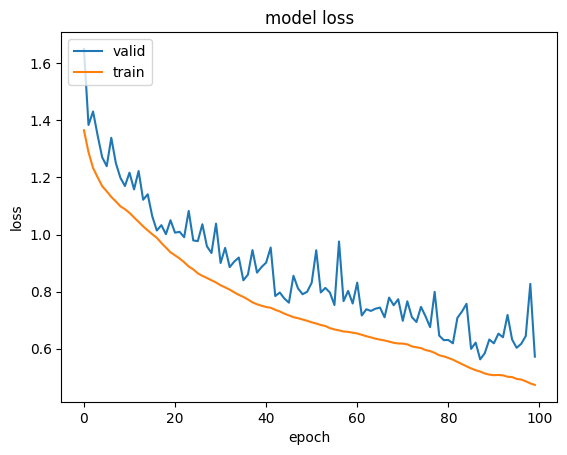

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['valid', 'train'], loc='upper left')
plt.show()

In [6]:
preds = model.predict(dttrain)
preds = np.asanyarray(preds)
preds = np.reshape(preds, (batch_size, max_seq_len, 1, vocab_size))
print(preds.shape)

32/32 [==============================] - 1s 346ms/step
(32, 3063, 1, 50000)



In [25]:
for i in dttest.take(1):
    X = np.squeeze(i[0][0][0].numpy())
    y = np.squeeze(i[1][0].numpy())
    y_pred = np.argmax(tf.squeeze(preds).numpy(), axis=1)
    print("Original Text: ", tokenizer.decode(X))
    print("------------------------------------------")
    print("Real Summarized Text: ", tokenizer.decode(y))
    print("------------------------------------------")
    print("Predicted Summarized Text: ", tokenizer.decode(y_pred))
    break

Original Text:  it was another momentous night in barcelonas proud european history neymar and luis suarez rampaging through paris saintgermains defence to put one foot in the champions league semifinals and barcelonas second of the night in the th minute when suarez stormed through nutmegged david luiz and finished was their th goal in the competition the landmark has been achieved in matches since when the european champions clubs cup became the modern champions league we know and love the two goals scored by luis suarez against psg took barcelona past champions league goals barcelona have reached the landmark in champions league matches since  barcelona won the quarterfinal firstleg match to put themselves in control of the tie barcelona still have a little way to go before they catch real madrids champions league goals table courtesy of opta however barcelona still have a some way to go to match the goals scored in the competition by their great rivals real madrid the spanish giant